Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 15
LEARNING_RATE = 3e-5
BATCH_SIZE = 128
LAYERS_TO_TRAIN = 0

In [2]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [3]:
import os
import json
import warnings
import logging
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, 
    brier_score_loss, fbeta_score
)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import AdamW
from transformers import DistilBertTokenizer, DistilBertModel

c:\Users\Hugo\git\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
14126,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...,1
14127,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra...",1
14128,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...,1
14129,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

,model,id,text,ai_generated
0,Human,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,Human,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,Human,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,Human,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,Human,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


In [8]:
df = pd.concat([df_generated, df_human])[['text', 'ai_generated', 'id']]
df

,text,ai_generated,id
0,Inaugural Address: President Joseph R. Biden J...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
1,Setting the Record Straight: Fact-Checking the...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
2,Joe Biden Takes the Oath of Office as 46th Pre...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
3,Joe Biden Takes Oath as 46th President of Unit...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
4,Amanda Gorman's Inspiring Poem Celebrates Hope...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
...,...,...,...
1082,How amateur detectives on social media helped ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1083,Authorities searching for missing 22-year-old ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1084,Univ. of Wisconsin Oshkosh student helping Gab...,0,articles-cleaned-truncated/news-2021-01-01-202...
1085,Did the Internet Actually Help Find Gabby Peti...,0,articles-cleaned-truncated/news-2021-01-01-202...


## Make combinations of text pairs

In [9]:
test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 4)
val shape: (1904, 4)
test shape: (3808, 4)


In [10]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for _, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [11]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [12]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


# Model

In [13]:
# Tokenizador y modelo
model_name = "Lau123/distilbert-base-uncased-detect_ai_generated_text"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
individual_model = DistilBertModel.from_pretrained(model_name, num_labels=2)

In [14]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.transformer.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
transformer.layer.0.attention.q_lin.weight: requires_grad = False
transformer.layer.0.attention.q_lin.bias: requires_grad = False
transformer.layer.0.attention.k_lin.weight: requires_grad = False
transformer.layer.0.attention.k_lin.bias: requires_grad = False
transformer.layer.0.attention.v_lin.weight: requires_grad = False
transformer.layer.0.attention.v_lin.bias: requires_grad = False
transformer.layer.0.attention.out_lin.weight: requires_grad = False
transformer.layer.0.attention.out_lin.bias: requires_grad = False
transformer.layer.0.sa_layer_norm.weight: requires_grad = False
transformer.layer.0.sa_layer_norm.bias: requires_grad = False
transformer.layer.0.ffn.lin1.weight: requires_grad = False
transformer.layer.0.ffn.lin1.bias: requires_grad = False
transformer.laye

In [15]:
class TransformerClass(torch.nn.Module):
    def __init__(self, bert_model):
        super(TransformerClass, self).__init__()
        self.l1 = bert_model
        self.l2 = torch.nn.Linear(768, 768)
        self.l3 = torch.nn.Dropout(0.)
        self.l4 = torch.nn.CosineSimilarity(dim=1)
        self.l5 = torch.nn.Linear(1, 1)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
        last_hidden_state_a = self.l1(ids_0, attention_mask=mask_0).last_hidden_state[:, 0]
        last_hidden_state_b = self.l1(ids_1, attention_mask=mask_1).last_hidden_state[:, 0]

        x_a, x_b = self.l2(last_hidden_state_a), self.l2(last_hidden_state_b)
        x_a, x_b = F.gelu(self.l3(x_a)), F.gelu(self.l3(x_b))
        sem_sim = self.l4(x_a, x_b).unsqueeze(1) 
        return torch.sigmoid(self.l5(sem_sim))

model = TransformerClass(individual_model)
model.to(device)

TransformerClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

# Training

## Loss and optimizer

In [16]:
loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

c:\Users\Hugo\git\NLP\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Data Generators

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())
        inputs0 = self.tokenizer(comment_text_1, 
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        inputs1 = self.tokenizer(comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids_0': torch.tensor(inputs0.input_ids, dtype=torch.long),
            'mask_0': torch.tensor(inputs0.attention_mask, dtype=torch.long),
            'token_type_ids_0': torch.tensor(inputs0.token_type_ids, dtype=torch.long),
            'ids_1': torch.tensor(inputs1.input_ids, dtype=torch.long),
            'mask_1': torch.tensor(inputs1.attention_mask, dtype=torch.long),
            'token_type_ids_1': torch.tensor(inputs1.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }


In [18]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [19]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [20]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [21]:
# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1-brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }

## Training

In [22]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_siames_preentrenado/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"


# Entrenamiento y validación
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value}")

Starting Epoch 1/15
* Training


Training: 100%|██████████| 69/69 [01:56<00:00,  1.69s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/15
Train Loss: 0.6989377037338589
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5005787626986176
  brier: 0.25141300698775276
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6161695266310909
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5168646502718734
  brier: 0.25123822183302713
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6194616611766872
Starting Epoch 2/15
* Training


Training: 100%|██████████| 69/69 [01:54<00:00,  1.66s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/15
Train Loss: 0.6958215150280275
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.502551420641135
  brier: 0.25095083576186394
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6166564924647722
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5165312448508815
  brier: 0.2508779327185091
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6194670379153923
Starting Epoch 3/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.65s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/15
Train Loss: 0.6952030736467113
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5037912907446203
  brier: 0.2507459853971472
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6169454365584125
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5154731010051079
  brier: 0.2507052428614718
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192899471176452
Starting Epoch 4/15
* Training


Training: 100%|██████████| 69/69 [01:54<00:00,  1.66s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/15
Train Loss: 0.6948254497154899
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5045693694631641
  brier: 0.2506149834234021
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6171272526968703
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5153147656121272
  brier: 0.2505926797137693
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192807926685895
Starting Epoch 5/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.65s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/15
Train Loss: 0.6945449519848478
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5050256866939115
  brier: 0.2505096497711403
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6172395828734721
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5150534478497282
  brier: 0.2504961469406463
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192478356707343
Starting Epoch 6/15
* Training


Training: 100%|██████████| 69/69 [01:52<00:00,  1.63s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/15
Train Loss: 0.6943085962447567
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5055312971338878
  brier: 0.25041582610123214
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.617359469695449
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.514967843755149
  brier: 0.25040629008136917
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192486862236738
Starting Epoch 7/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.65s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/15
Train Loss: 0.6941240922264431
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5060132809177905
  brier: 0.2503309943760787
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6174728327972602
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5153263511286867
  brier: 0.250325578817377
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6193365299511798
Starting Epoch 8/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/15
Train Loss: 0.6939136472301207
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5065452809124196
  brier: 0.2502552183309475
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6175943880052124
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5150167603806228
  brier: 0.25025363301429854
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192890009621828
Starting Epoch 9/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/15
Train Loss: 0.6937709424806677
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5071053746795167
  brier: 0.2501847557191937
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6177204992809825
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5143467313395946
  brier: 0.25018637426629403
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.619168446903578
Starting Epoch 10/15
* Training


Training: 100%|██████████| 69/69 [01:52<00:00,  1.63s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/15
Train Loss: 0.6936140328213789
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5075192930367416
  brier: 0.25011907881246387
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6178164183337735
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5146917222771461
  brier: 0.2501218618950353
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192503475653399
Starting Epoch 11/15
* Training


Training: 100%|██████████| 69/69 [01:52<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/15
Train Loss: 0.6934820871422256
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5079784764519961
  brier: 0.25006040121285006
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6179199905367471
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5150238404185203
  brier: 0.25006401264947703
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6193283410427265
Starting Epoch 12/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/15
Train Loss: 0.6933368470357812
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5082880760217483
  brier: 0.25000218613345626
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6179935534665763
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5149099161723514
  brier: 0.2500071302445915
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6193169326744699
Starting Epoch 13/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/15
Train Loss: 0.6932314642961475
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5087591631402268
  brier: 0.24994607683353093
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6180989927502571
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5147091005519855
  brier: 0.2499524335141079
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192877088964934
Starting Epoch 14/15
* Training


Training: 100%|██████████| 69/69 [01:53<00:00,  1.64s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/15
Train Loss: 0.6930978816488514
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5092664261550542
  brier: 0.249892179355569
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.618211224848815
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5148893196984676
  brier: 0.24989968414372327
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6193343025998667
Starting Epoch 15/15
* Training


Training: 100%|██████████| 69/69 [01:52<00:00,  1.63s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/15
Train Loss: 0.6929845956788547
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5096319292334397
  brier: 0.24984005564623313
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6182947502063592
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5150450805322129
  brier: 0.2498484614768472
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.619375699299991


## Metrics graphic

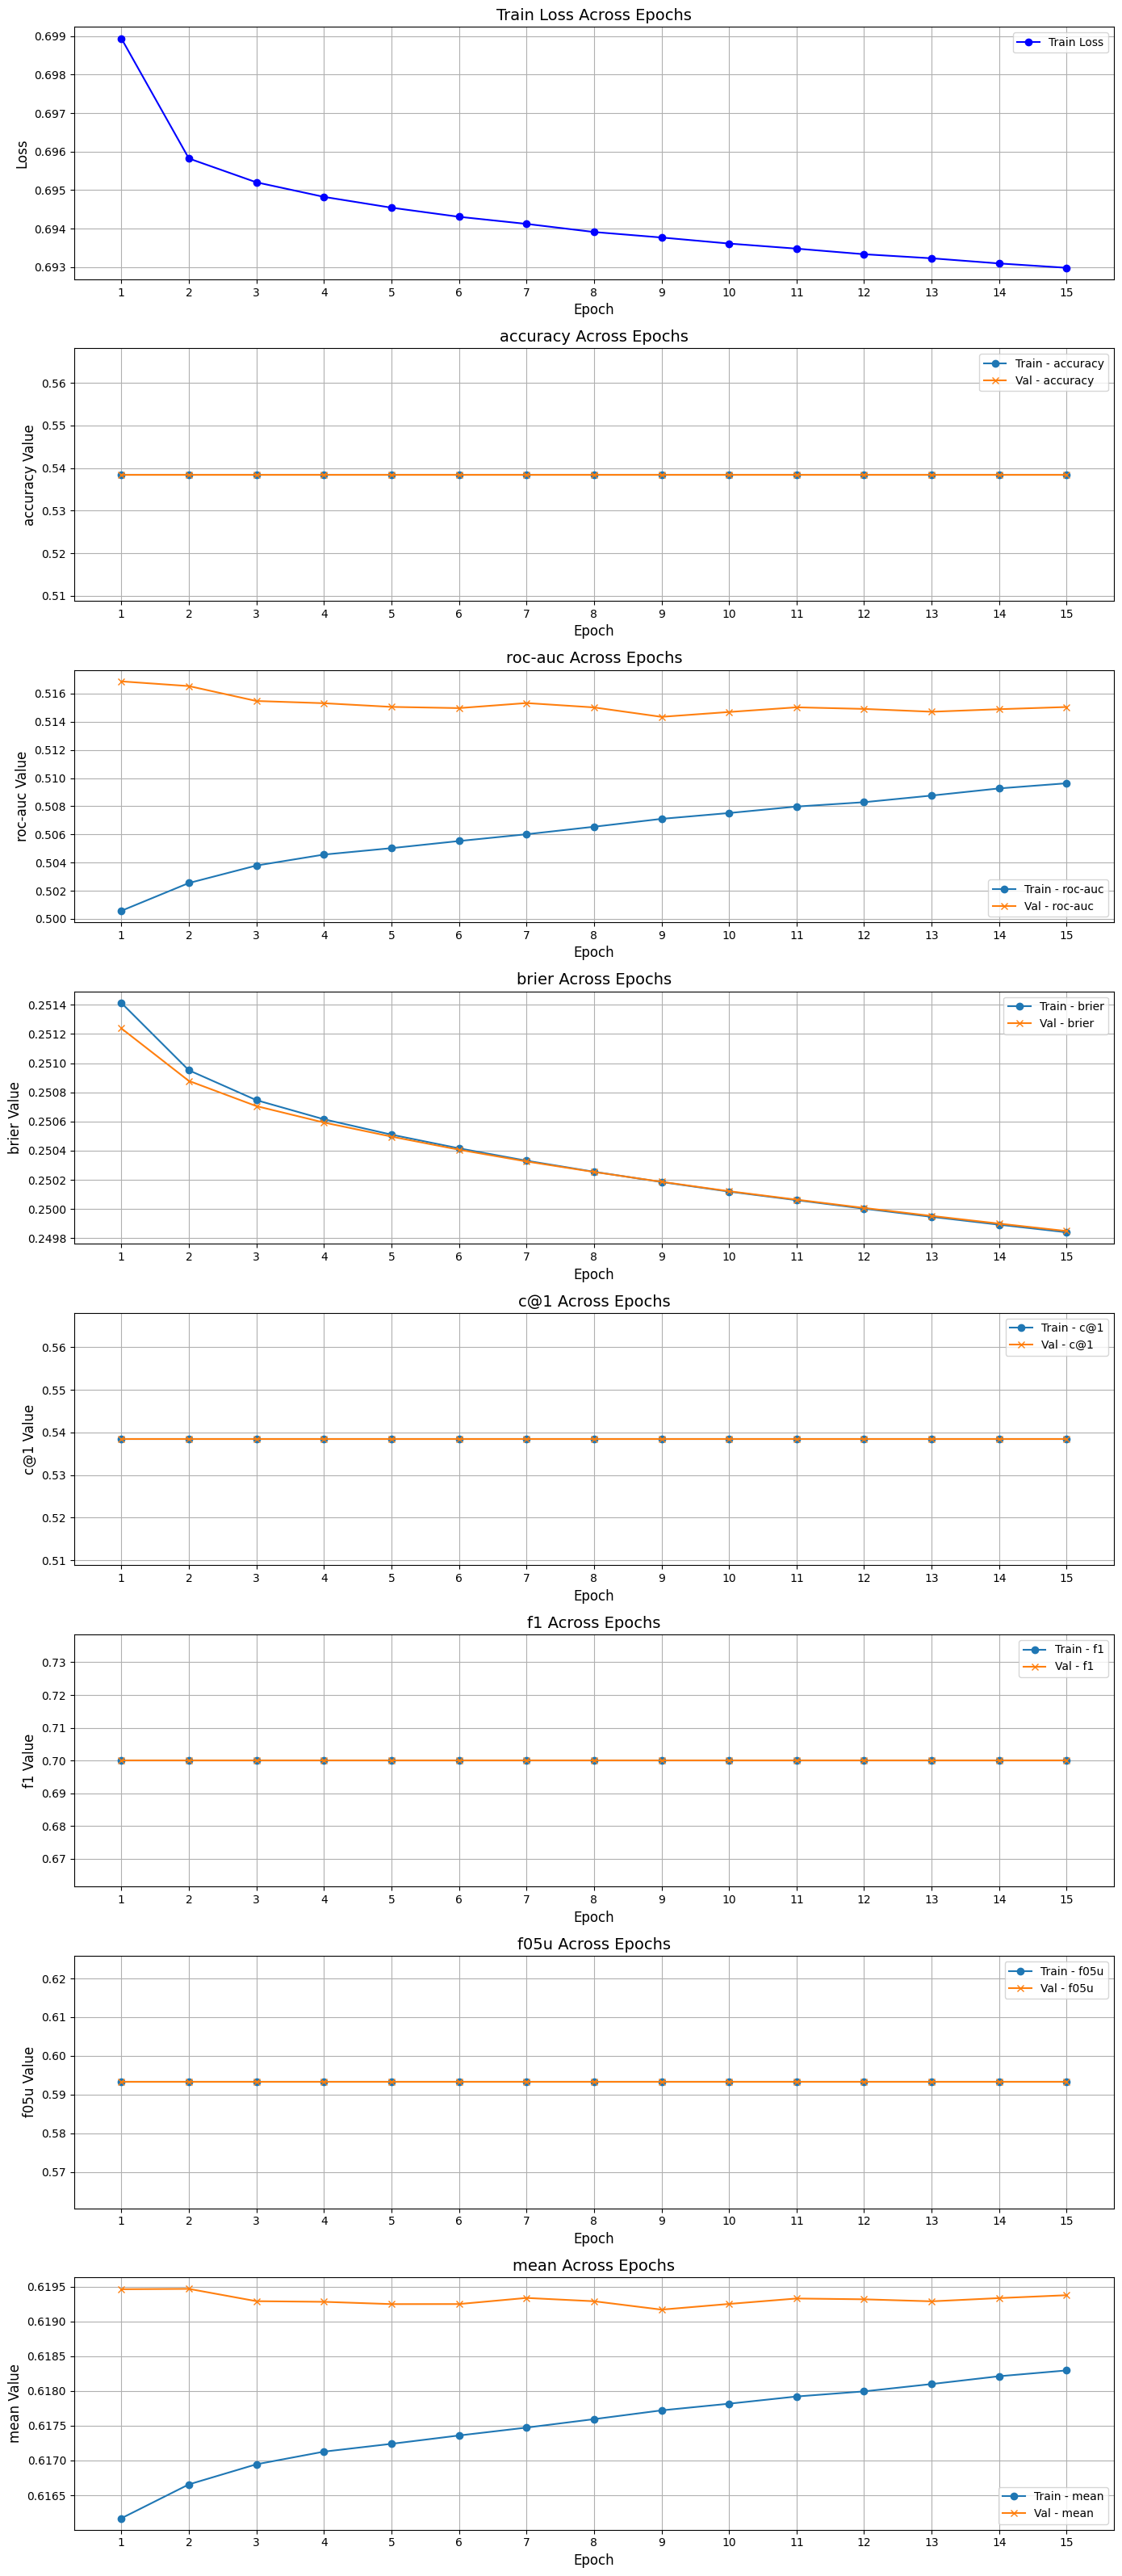

In [23]:
metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Evaluate test

In [24]:
# Evaluación final en el conjunto de prueba
test_metrics = evaluate(model, test_loader, device)

print("Test Metrics:")
for metric_name, value in test_metrics.items():
    print(f"  {metric_name}: {value:.8f}")

Test Metrics:
  accuracy: 0.53846154
  roc-auc: 0.49667576
  brier: 0.24983721
  c@1: 0.53846154
  f1: 0.70000000
  f05u: 0.59322034
  mean: 0.61570409
